# Lonlat ms diagnosis on main combination
- compute residual
- compute correlated and uncorrelated part of each term -> evaluate contribution in th H1 hypothesis (correlated part = physical signal)
- evaluate H1

In [1]:
import numpy as np
import pandas as pd
import xarray as xr

import os
from glob import glob

import matplotlib.pyplot as plt


import cartopy.crs as ccrs
import cartopy.feature as cfeature
import cartopy.geodesic as cgeo
crs = ccrs.PlateCarree()
import cmocean.cm as cm

import histlib.matchup as match
from histlib.diagnosis import global_ms_drifter_sat_year, compute_sum_ms, TER_id, C_x, true_err_x, plot_closure_bar, plot_cor_uncor_part
from histlib.cstes import labels, zarr_dir, matchup_dir
from histlib.matchup import _data_var, _stress_var, _aviso_var

/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.scheduler.transition-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(
/home1/datahome/mdemol/.miniconda3/envs/histenv2/lib/python3.9/site-packages/dask/config.py:742: FutureWarning: Dask configuration key 'distributed.comm.recent-messages-log-length' has been deprecated; please use 'distributed.admin.low-level-log-length' instead
  warnings.warn(


In [2]:
DL =25*1e3 #meters
DT = int(1800) #seconds
dl=5
id_aviso = 'aviso__0__adt__es_cstrio_z15__alti_x'
id_co = 'co__0__adt_filtered_ocean_tide_internal_tide__es_cstrio_z15__alti_x'

var =['nb_coloc_bin',
 'exc_acc_co__0__adt_filtered__es_cstrio_z15__drifter_x',
 'exc_coriolis_co__0__adt_filtered__es_cstrio_z15__drifter_x',
 'exc_ggrad_co__0__adt_filtered__es_cstrio_z15__drifter_x',
 'exc_wind_co__0__adt_filtered__es_cstrio_z15__drifter_x',
 'sum_co__0__adt_filtered__es_cstrio_z15__drifter_x',
 'exc_acc_aviso__0__adt__es_cstrio_z15__alti_x',
 'exc_coriolis_aviso__0__adt__es_cstrio_z15__alti_x',
 'exc_ggrad_aviso__0__adt__es_cstrio_z15__alti_x',
 'exc_wind_aviso__0__adt__es_cstrio_z15__alti_x',
 'sum_aviso__0__adt__es_cstrio_z15__alti_x',
 'drifter_acc_x_0',
 'drifter_coriolis_x_0',
 'alti_ggx_adt_filtered',
 'es_cstrio_z15_drifter_wd_x',
 'drifter_acc_x_0',
 'drifter_coriolis_x_0',
 'aviso_alti_ggx_adt',
 'es_cstrio_z15_alti_wd_x']

id_co_dic =  {'acc':'drifter_acc_x_0','coriolis':'drifter_coriolis_x_0','ggrad':'alti_ggx_adt_filtered_ocean_tide_internal_tide','wind':'es_cstrio_z15_alti_wd_x'}
id_aviso_dic =  {'acc':'drifter_acc_x_0','coriolis':'drifter_coriolis_x_0','ggrad':'aviso_alti_ggx_adt','wind':'es_cstrio_z15_alti_wd_x'}

# Datasets 

In [3]:
files = glob(os.path.join(zarr_dir+'_ok',f'mslonlat/mslonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files = [f for f in files if 'gps' in f]
dsms = xr.open_mfdataset(files).rename({'nb_coloc_bin':'nb_coloc'})
files = glob(os.path.join(zarr_dir+'_ok',f'meanlonlat/meanlonlat_{int(DL//1000)}_{DT}_{dl}_drogued_*.zarr'))
files = [f for f in files if 'gps' in f]
dsmean = xr.open_mfdataset(files).rename({'nb_coloc_bin':'nb_coloc'})

In [4]:
list =  np.intersect1d(list(dsms.variables), list(dsmean.variables))
dsmean = dsmean[list].compute()
dsms = dsms[list].compute()

In [5]:
ds, mslow, msup = global_ms_drifter_sat_year(dsmean, dsms, alpha=0.01)
mserr = ((msup-mslow)/2).where(ds.nb_coloc>0)
ds =ds.where(ds.nb_coloc>0)

<xarray.DataArray 'nb_coloc' (latbin: 36, lonbin: 72)>
array([[ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 2.,  3.,  9., ...,  8.,  0., 13.],
       ...,
       [ 0.,  0.,  3., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.],
       [ 0.,  0.,  0., ...,  0.,  0.,  0.]])
Coordinates:
  * latbin   (latbin) float64 -87.5 -82.5 -77.5 -72.5 ... 72.5 77.5 82.5 87.5
  * lonbin   (lonbin) float64 -177.5 -172.5 -167.5 -162.5 ... 167.5 172.5 177.5


______________________
# Count

In [6]:
min_coloc_bin = 20
ds['nb_coloc'].attrs = {'long_name': 'Number of colocations per bin'}

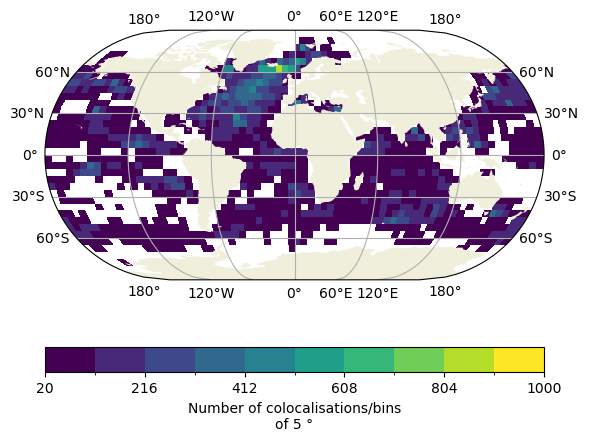

In [7]:
fig = plt.figure(figsize=(6,5))
ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=0))
ax.add_feature(cfeature.LAND, zorder=2)
ds_ = ds.where(ds.nb_coloc > min_coloc_bin).nb_coloc
ds_.attrs['long_name']=f'Number of colocalisations/bins of {dl} °'
ds_.plot(x="lonbin", y="latbin", ax=ax, transform=ccrs.PlateCarree(),levels=11, vmin=20, vmax=1000, cbar_kwargs={'location':'bottom'})
#ax.set_title('(a)')# \n Colocalisations with GPS drifters')
gl = ax.gridlines(draw_labels=True,)
fig.tight_layout()

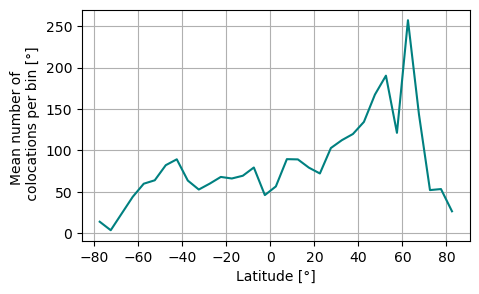

In [8]:
fig, ax = plt.subplots(1,1, figsize=(5,3))
ds.nb_coloc.mean('lonbin').plot(ax=ax, c='teal')
ax.set_xlabel('Latitude [°]')
ax.set_ylabel('Mean number of \n colocations per bin [°]')
ax.grid()

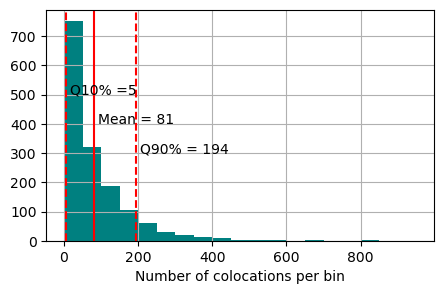

In [9]:
dd = 10

fig, ax = plt.subplots(1,1, figsize=(5,3))
hist = ds.nb_coloc.plot.hist(bins=np.arange(0,1000, 50), ax=ax, color='teal')
mean = ds.nb_coloc.mean().values
q90 = ds.nb_coloc.quantile(0.9).values
q10 = ds.nb_coloc.quantile(0.1).values
ax.axvline(mean, color = 'red')
ax.axvline(q90, color = 'red', ls='--')
ax.axvline(q10, color = 'red', ls='--')
ax.annotate(f'Q10% ={int(q10)}',(q10+dd, 500))
ax.annotate(f'Mean = {int(mean)}',(mean+dd, 400))
ax.annotate(f'Q90% = {int(q90)}',(q90+dd, 300))
ax.grid()

______________________
# Closure efficiancy : $\langle S^2 \rangle$ and $RSE = \frac{\langle S^2 \rangle}{\sum_i \langle x_i^2 \rangle}$
- AVISO more efficient

In [29]:
min_coloc_bin =50
ds = ds.where(ds.nb_coloc>min_coloc_bin)
mserr = mserr.where(ds.nb_coloc>min_coloc_bin)

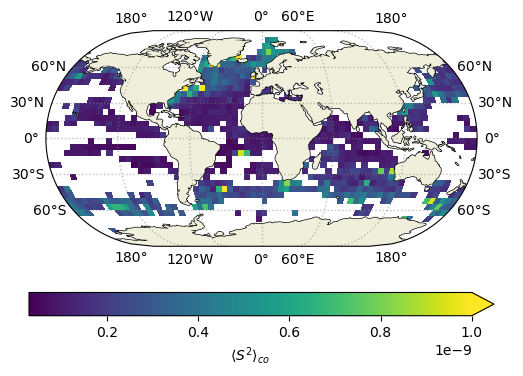

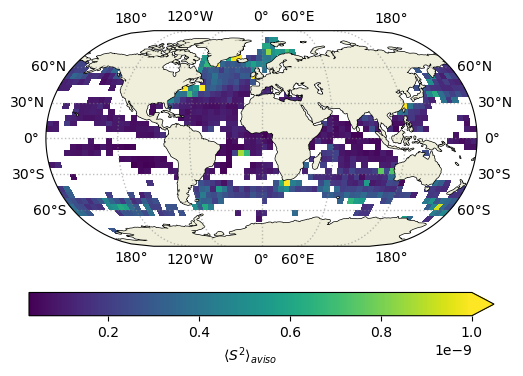

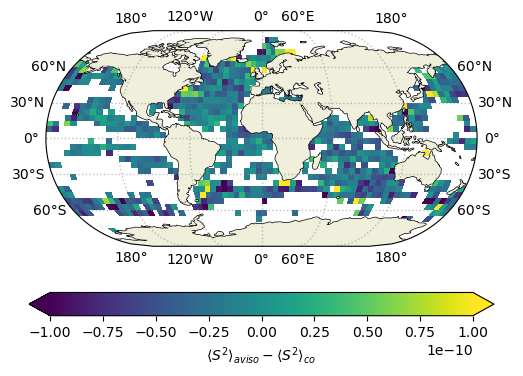

In [30]:
# CO 
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=0))
ax.add_feature(cfeature.LAND, zorder=2)
ds['sum_'+id_co].attrs = {'long_name':r'$\langle S^2 \rangle_{co}$'}
ds['sum_'+id_co].plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-9,  ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

# AVISO
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=0))
ax.add_feature(cfeature.LAND, zorder=2)
ds['sum_'+id_aviso].attrs = {'long_name':r'$\langle S^2 \rangle_{aviso}$'}
ds['sum_'+id_aviso].plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-9, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

# DIFF 
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.EckertIII(central_longitude=0))
ax.add_feature(cfeature.LAND, zorder=2)
diff = ds['sum_'+id_aviso]-ds['sum_'+id_co]
diff.attrs = {'long_name':r'$\langle S^2 \rangle_{aviso} - \langle S^2 \rangle_{co}$'}
diff.plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-10, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

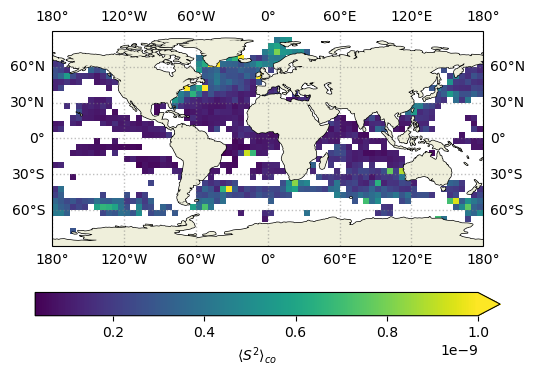

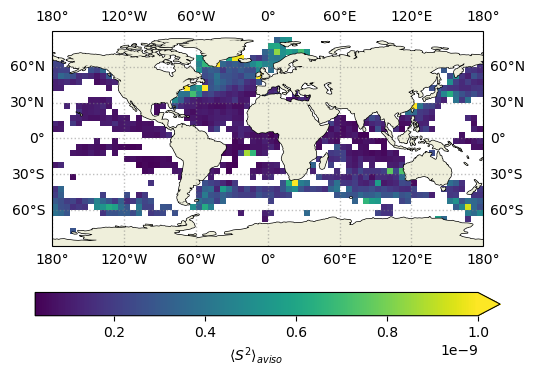

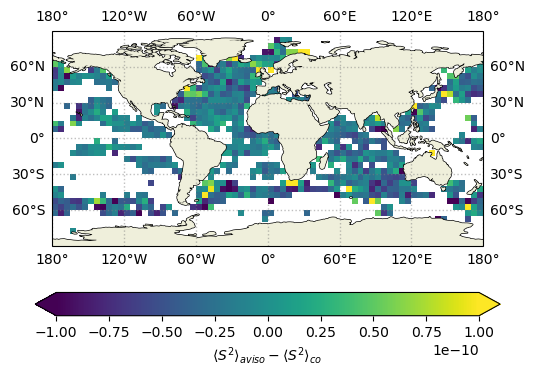

In [31]:
# CO 
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2)
ds['sum_'+id_co].attrs = {'long_name':r'$\langle S^2 \rangle_{co}$'}
ds['sum_'+id_co].plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-9,  ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

# AVISO
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2)
ds['sum_'+id_aviso].attrs = {'long_name':r'$\langle S^2 \rangle_{aviso}$'}
ds['sum_'+id_aviso].plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-9, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

# DIFF 
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2)
diff = ds['sum_'+id_aviso]-ds['sum_'+id_co]
diff.attrs = {'long_name':r'$\langle S^2 \rangle_{aviso} - \langle S^2 \rangle_{co}$'}
diff.plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-10, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

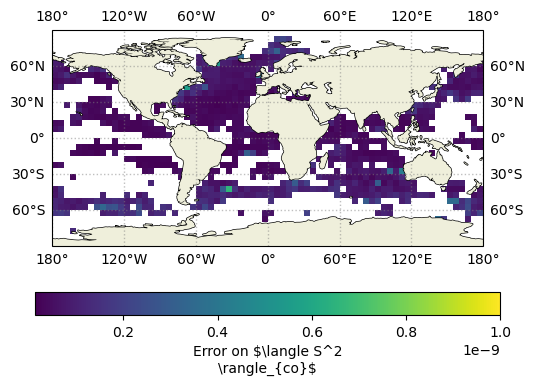

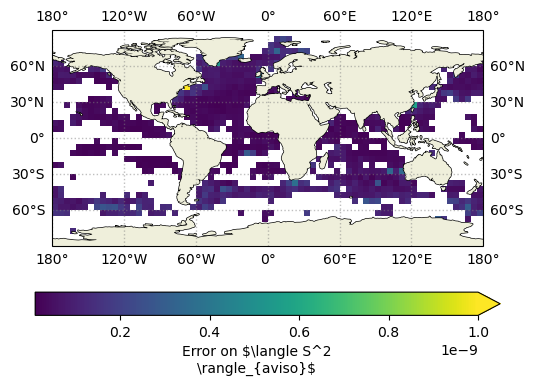

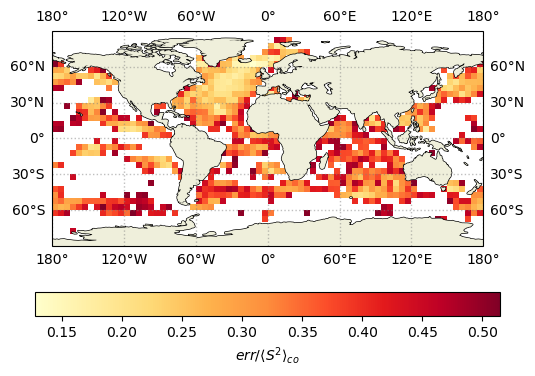

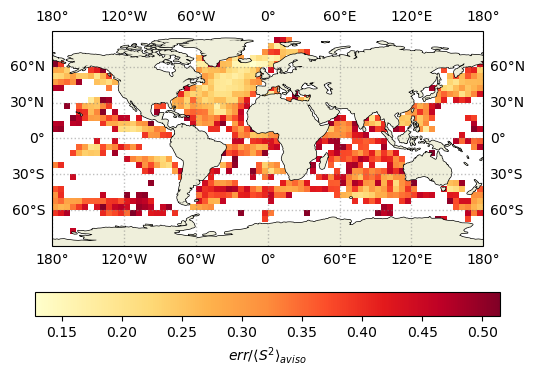

In [32]:
# CO 
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2)
mserr['sum_'+id_co].attrs = {'long_name':r'Error on $\langle S^2 \rangle_{co}$'}
mserr['sum_'+id_co].plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-9,  ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

# AVISO
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2)
mserr['sum_'+id_aviso].attrs = {'long_name':r'Error on $\langle S^2 \rangle_{aviso}$'}
mserr['sum_'+id_aviso].plot(x='lonbin', y='latbin', cmap='viridis', vmax = 1e-9, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

# RELATIVE ERRO 
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2)
rel = (mserr['sum_'+id_co]/ds['sum_'+id_co])
rel.attrs = {'long_name':r'$err/ \langle S^2 \rangle_{co}$'}
rel.plot(x='lonbin', y='latbin', cmap='YlOrRd', ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

# RELATIVE ERRO 
fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
ax.add_feature(cfeature.LAND, zorder=2)
rel = (mserr['sum_'+id_aviso]/ds['sum_'+id_aviso])
rel.attrs = {'long_name':r'$err/ \langle S^2 \rangle_{aviso}$'}
rel.plot(x='lonbin', y='latbin', cmap='YlOrRd', ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

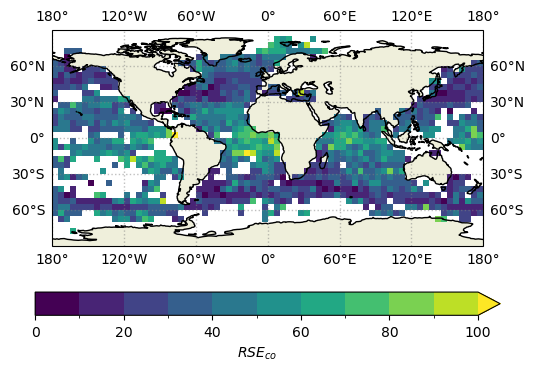

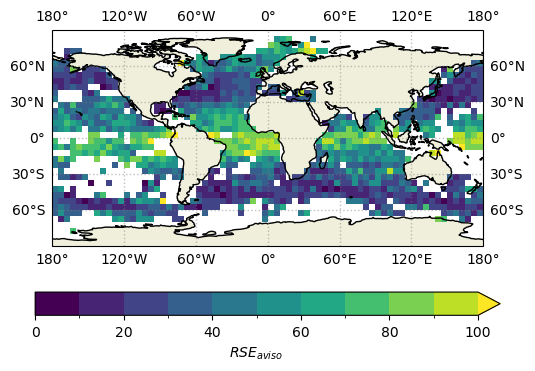

In [20]:
def compute_sum_ms(ds, id_, dic=None):
    if dic == None :
        dic = ds['sum_'+id_].attrs
    return ds[dic['acc']]+ds[dic['coriolis']]+ds[dic['ggrad']]+ds[dic['wind']]
    
def RSE_id(ds, id_, dic):
    acc = ''+dic['acc']
    cor = ''+dic['coriolis']
    ggrad = ''+dic['ggrad']
    wd = ''+dic['wind']
    return ds['sum_'+id_]/(ds[acc]+ds[cor]+ds[ggrad]+ds[wd])*100

fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
RSE = RSE_id(ds, id_co, id_co_dic )
RSE.attrs = {'long_name':r'$RSE_{co}$'}
RSE.plot(x='lonbin', y='latbin', cmap='viridis', levels=11, vmin = 0, vmax = 100, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')


fig = plt.figure(figsize=(6,4))
ax = fig.add_subplot(1,1,1, projection=ccrs.PlateCarree())
RSE = RSE_id(ds, id_aviso, id_aviso_dic )
RSE.attrs = {'long_name':r'$RSE_{aviso}$'}
RSE.plot(x='lonbin', y='latbin', cmap='viridis', levels=11,vmin = 0, vmax = 100, ax=ax, transform=ccrs.PlateCarree(), cbar_kwargs={'location':'bottom'})
ax.add_feature(cfeature.LAND)
ax.coastlines()
gl = ax.gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                  linewidth=1, color='gray', alpha=0.5, linestyle=':')

______________________
# $x$ contribution : $C_{x_i} = \langle S_{-x_i}^2\rangle-\langle S^2 \rangle$
## Under H1 :
$Rc_{x_i} = \frac{\langle \hat{x}^2 \rangle - \langle {x_i^{e}}^2\rangle}{\sum_i \langle x_i^2 \rangle}$  

 - $RC_{x_i}<0 \Leftrightarrow \langle \hat{x}^2 \rangle < \langle {x_i^{e}}^2\rangle$ more error than signal is added
 - $RC_{x_i}>0 \Leftrightarrow \langle \hat{x}^2 \rangle > \langle {x_i^{e}}^2\rangle$ more signal than error is added
 - The bigger $Rc_x$ is, the better closure we have
Results :
 - $RC_x$<0 for inertial acceleration and wind

In [21]:
def plot_stat_lonlat(variables, ds=1, cmap='viridis', title =1 , cmap_label =1 ,fig_title=1,**kwargs):
    lv = len(variables)
    if isinstance(variables[0],str):
        variables = [ds[v] for v in variables]
        if isinstance(ds, int) : 
            assert False, 'give dataset'
    nrows = int(np.ceil(lv/2))
    ncols = 2
    if lv == 1:
        nrows = 1
        ncols = 1
    # Define the figure and each axis for the 3 rows and 3 columns
    fig, axs = plt.subplots(nrows=nrows,ncols=ncols,
                            subplot_kw={'projection': ccrs.PlateCarree()},
                            figsize=(15,nrows*4))

    # axs is a 2 dimensional array of `GeoAxes`.  We will flatten it into a 1-D array
    if lv !=1:
        axs=axs.flatten()
    else : axs = [axs]

    #Loop over all of the variables
    for i in range(lv):

            # Contour plot
            if cmap_label != 1:
                variables[i].assign_attrs({'long_name':cmap_label[i]}).plot(x='lonbin', y='latbin', cmap=cmap, ax=axs[i],**kwargs)

            else : 
                variables[i].plot(x='lonbin', y='latbin', cmap=cmap, ax=axs[i], **kwargs)
            
            # Title each subplot with the name of the model
            if title != 1:
                axs[i].set_title(title[i], fontsize=14)

            # Draw the coastines for each subplot
            axs[i].coastlines()
            axs[i].add_feature(cfeature.LAND)
            #gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
            #          linewidth=1, color='gray', alpha=0.5, linestyle=':')
            gl = axs[i].gridlines(crs=ccrs.PlateCarree(), draw_labels=True,
                                  linewidth=1, color='gray', alpha=0.5, linestyle=':', xlabel_style = {'color': 'w'}, ylabel_style = {'color': 'w'})
            gl.xlabels_top = False
            gl.ylabels_right = False
    if isinstance(fig_title, str):
        fig.suptitle(fig_title)
    fig.tight_layout(rect=[0,0,1,1])#left, bottom, right, top (default is 0,0,1,1)
    # Delete the unwanted axes
    if lv !=1:
        for i in np.arange(lv,nrows*2):
            fig.delaxes(axs[i])

In [22]:
def plot_ms_lonlat(variables, ds, id_, dic, title=1, **kwargs):
    ticks = [r'$d_tu$', r'$-fv$', r'$g \partial_x \eta$', r'$\frac{1}{\rho}\partial_z\tau_x$']
    plot_stat_lonlat(variables, ds=ds, title = [r'$x =$'+ticks[i] for i in range(len(ticks))], **kwargs)

In [24]:
def RC_x(ds, id_, dic=None):
    if isinstance(id_, str):
        lab = ['acc', 'coriolis', 'ggrad', 'wind']
        s = compute_sum_ms(ds, id_, dic)
        Rc_x = xr.Dataset()
        for l in lab :
            Rc_x[l] = (ds['exc_'+l+'_'+id_] - ds['sum_'+id_])#/s*100
    return Rc_x
RCX = xr.concat([RC_x(ds, id_co, dic = id_co_dic), RC_x(ds, id_co, dic = id_co_dic)], dim =pd.Index([id_co, id_aviso], name='id_comb')) 

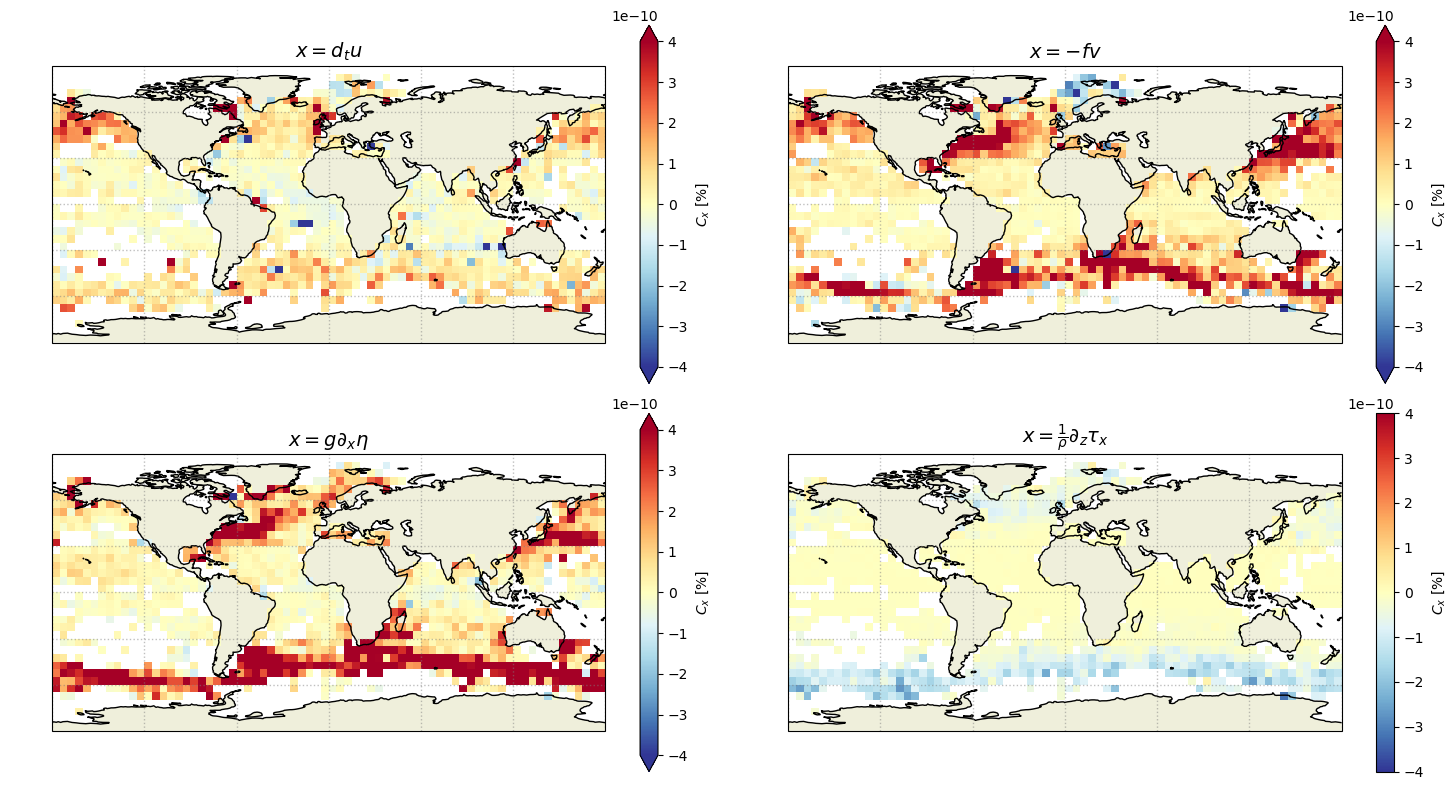

In [25]:
plot_ms_lonlat(['acc', 'coriolis', 'ggrad', 'wind'],RCX.sel(id_comb =id_co), id_co, id_co_dic, cmap_label = [r'$C_{x}$ [%]']*4, cmap = 'RdYlBu_r',vmin=-4e-10, vmax =4e-10)
              

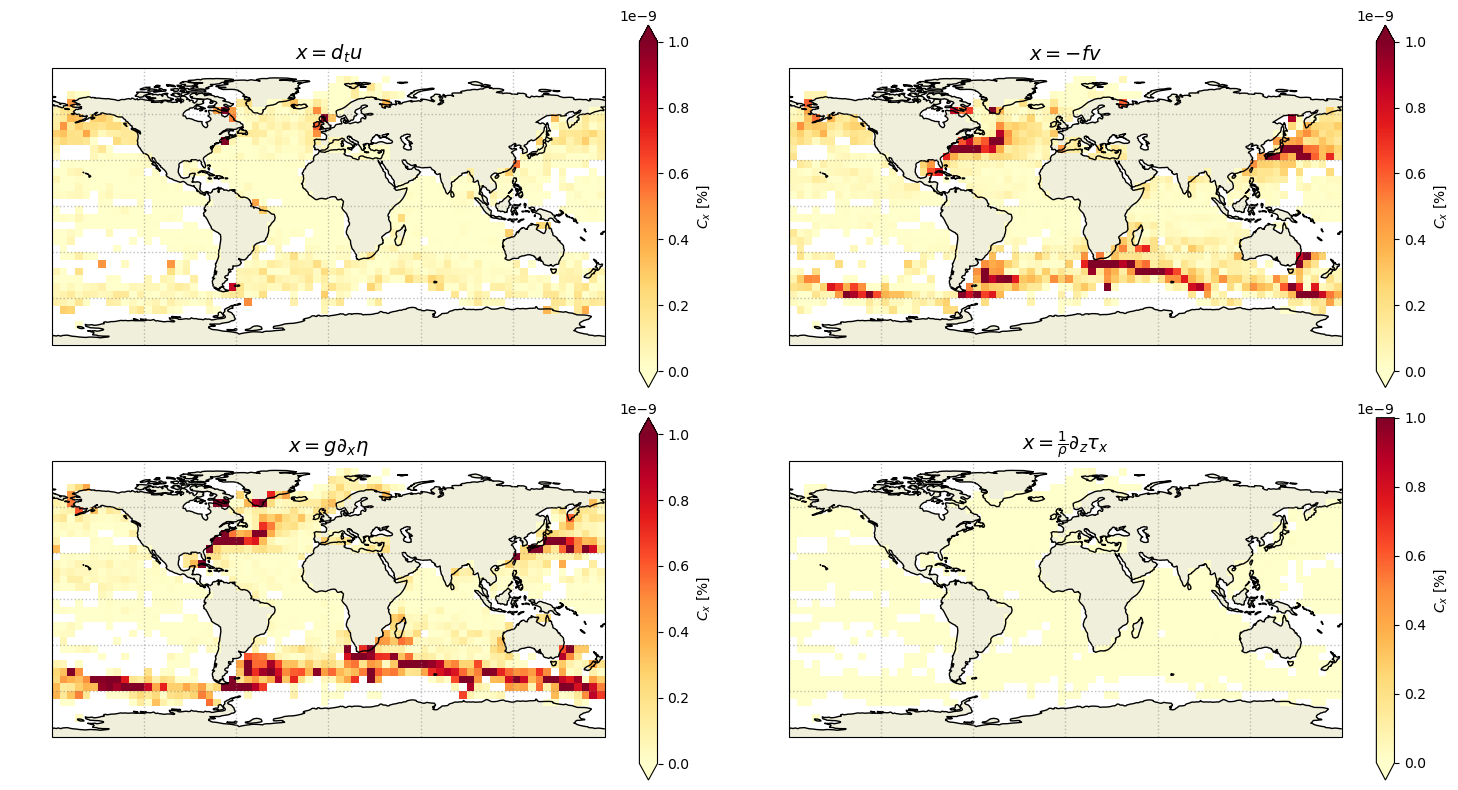

In [26]:
plot_ms_lonlat(['acc', 'coriolis', 'ggrad', 'wind'],RCX.sel(id_comb =id_co), id_co, id_co_dic, cmap_label = [r'$C_{x}$ [%]']*4, cmap = 'YlOrRd',vmin=0, vmax =10e-10)
              

________________________
# True/Error in $x$ 
$\langle \hat{x_i} \rangle +\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle+\langle \hat{x_i}{x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $
## Under H1

$\langle \hat{x_i} \rangle  = \frac{1}{2}(\langle x_i^2 \rangle - \langle S^2 \rangle +\langle S_{-x_i}^2 \rangle) $  

$\langle {x_i^{e}}^2 \rangle  = \frac{1}{2}(\langle x_i^2 \rangle + \langle S^2 \rangle -\langle S_{-x_i}^2 \rangle) $

In [33]:
def true_err_x(ds, id_, dic) :
    dso = xr.Dataset()
    for x in ['acc', 'coriolis', 'ggrad', 'wind']:
        X =dic[x]
        dso[x] = ds[X]
        dso['exc_'+x] = ds['exc_' + x +'_'+ id_]
        dso['true_'+x] = (ds[X] - ds['sum_'+id_] + ds['exc_' + x +'_'+ id_])/2
        dso['err_'+x] = (ds[X] + ds['sum_'+id_] - ds['exc_' + x +'_'+ id_])/2
    dso['S'] = ds['sum_'+id_]
    return dso
dsmss = xr.concat([true_err_x(ds, id_co, id_co_dic), true_err_x(ds, id_aviso, id_aviso_dic)], dim=pd.Index([id_co, id_aviso], name = 'id_comb'))

In [36]:
dsmssco = dsmss.sel(id_comb =id_co)
s = compute_sum_ms(ds, id_co, id_co_dic)
true_s = [dsmssco['true_'+v]/s for v in ['acc', 'coriolis', 'ggrad', 'wind']]

In [43]:
norm_err = [dsmssco['err_'+v]/dsmssco['true_'+v] for v in ['acc', 'coriolis', 'ggrad', 'wind']]

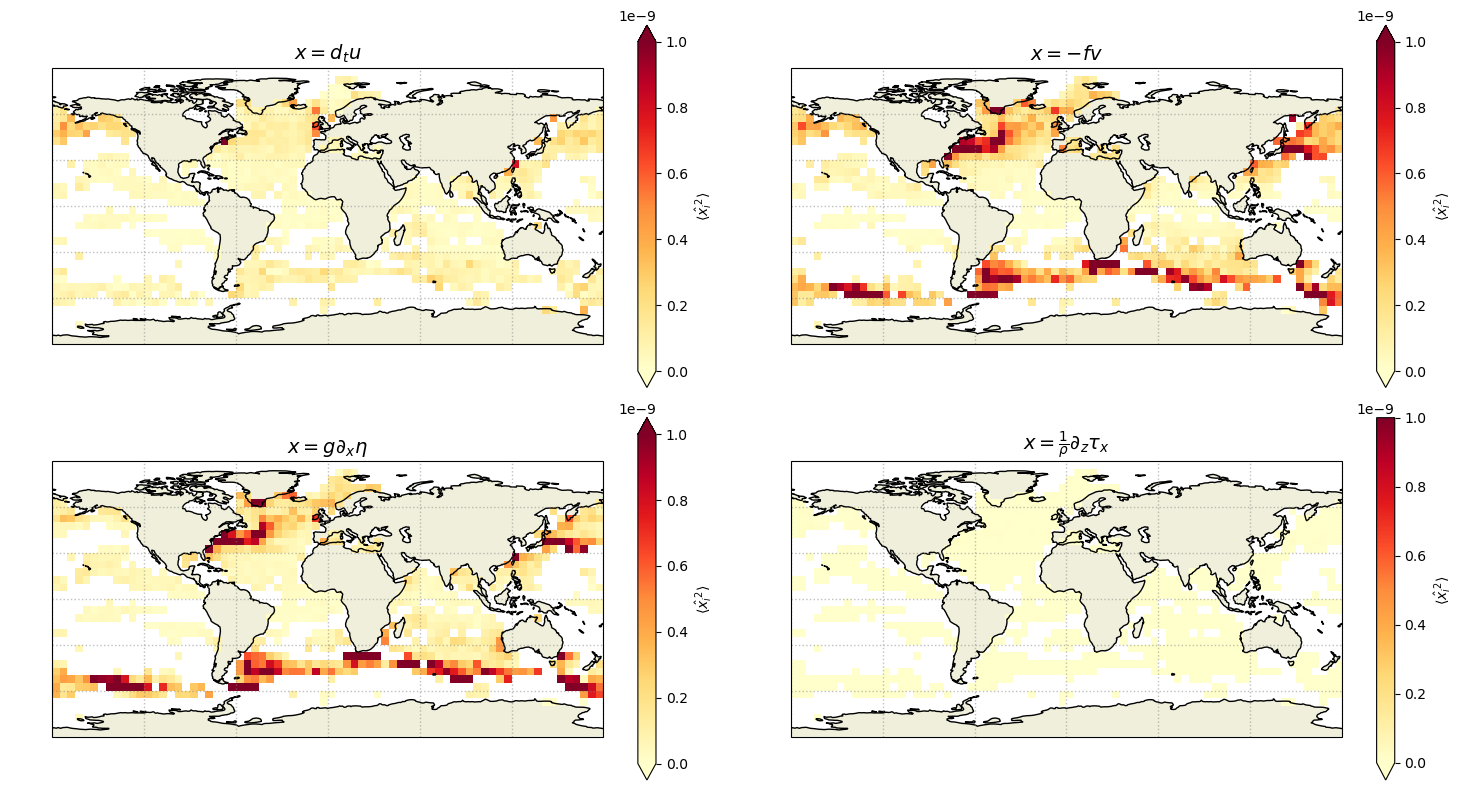

In [38]:
plot_ms_lonlat(['true_'+v for v in ['acc', 'coriolis', 'ggrad', 'wind']], dsmss.isel(id_comb =0), id_co, id_co_dic, vmin=0, vmax = 10e-10,cmap = 'YlOrRd', cmap_label = [r'$\langle \hat{x_i}^2 \rangle$']*4,)

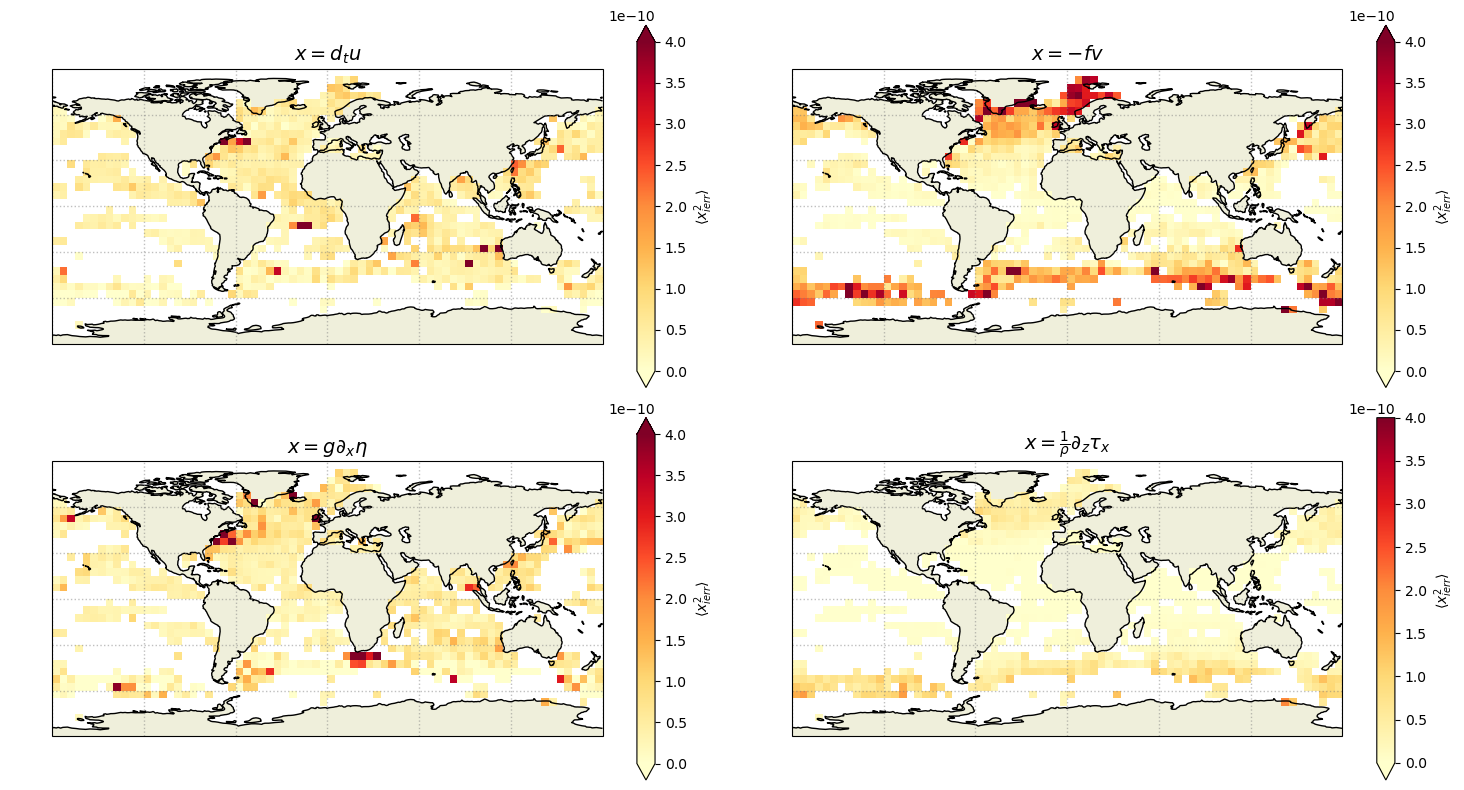

In [39]:
plot_ms_lonlat(['err_'+v for v in ['acc', 'coriolis', 'ggrad', 'wind']], dsmss.isel(id_comb =0), id_co, id_co_dic, cmap = 'YlOrRd',vmin=0,vmax=4e-10, cmap_label = [r'$\langle x_{ierr}^2 \rangle$']*4)

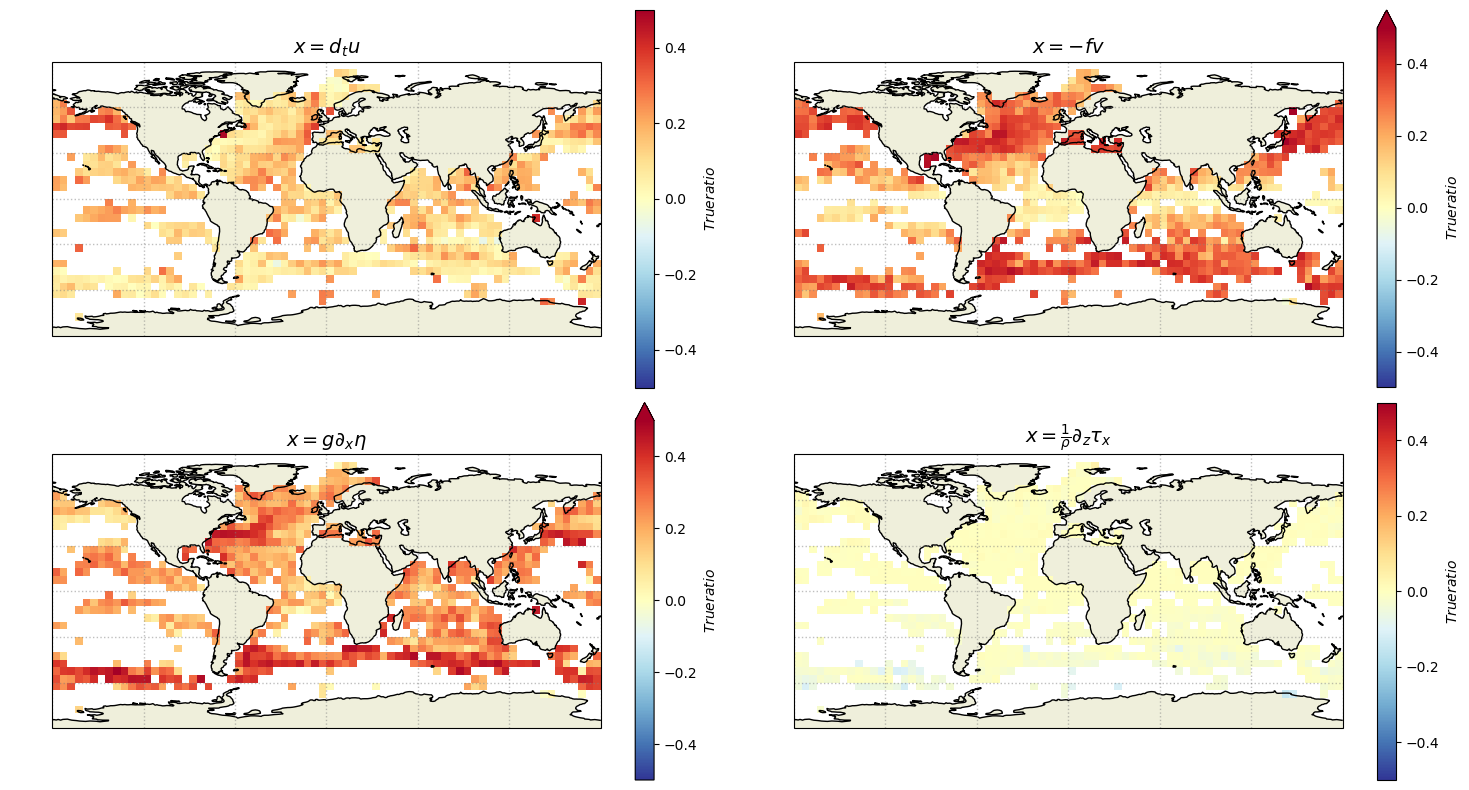

In [40]:
plot_ms_lonlat(true_s,1, id_co, id_co_dic,vmin=-0.5, vmax=0.5,  cmap = 'RdYlBu_r', cmap_label = [r'$True ratio$']*4,)

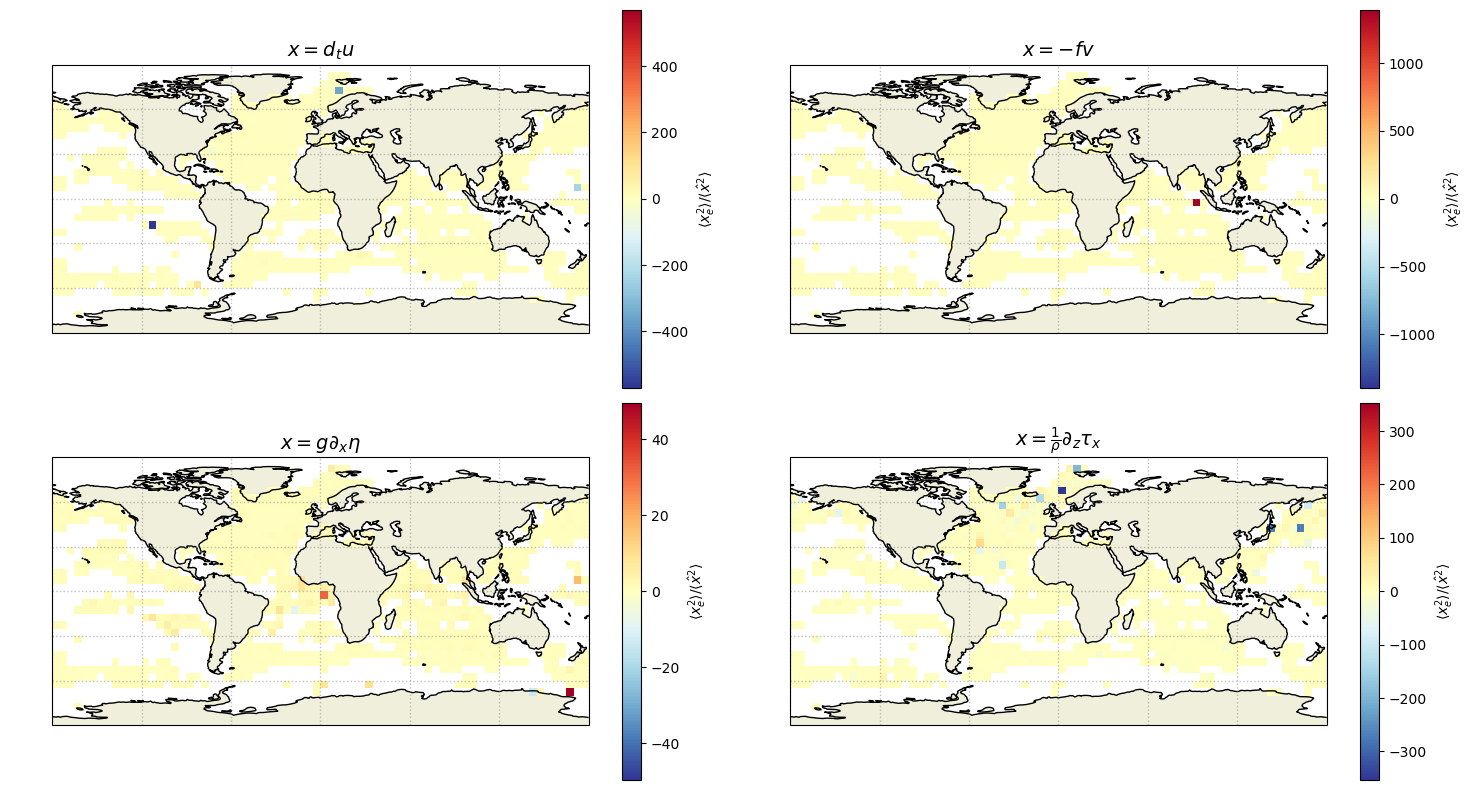

In [51]:
plot_ms_lonlat(norm_err,1, id_co, id_co_dic,  cmap = 'RdYlBu_r', cmap_label = [r'$\langle x_e^2\rangle / \langle \hat{x}^2 \rangle$']*4,)#faire en log

In [42]:
cluster.close()

NameError: name 'cluster' is not defined